# How do Positional Embeddings Work?

In modern transformer-based architectures, token sequences are processed in parallel rather than sequentially (as they were done in the older Recursive Neural Network (RNN) architectures). 
This provides a great performance boost as parallel operations always do. One key idea that enables this is positional encoding. 

Positional encodings incorporate position within the embedding. The model can thus learn to extract it and even compare embeddings to obtain the distance between them .

A formulation that is popularly used and was first introduced in the now famous Vaswani et al. (2017) paper is given below:

$$
p_{t,2j} = sin(\frac{t}{10000^{2j/d}}) \\
p_{t,2j+1} = cos(\frac{t}{10000^{2j/d}})
$$


Where $t$ is the token position, ($2j, 2j+1$) are adjacent embedding indices and $d$ is the embedding size. 
The angular frequency $\omega$ decays $10000^{-2j/d}$ exponentially with index i.

The position embeddings are then simply added to the word embeddings before the forward pass.

$$
w^{\prime}_t = w_t + p_t
$$

At first glance, this seems a bit strange. Why use sine and cosine? Why smaller for larger indices? 

I'll try to answer some of these questions.

## First, let's generate some sample embeddings 



In [1]:
sequence_length = 15
embedding_length = 9

import jax.numpy as jnp

def pos(t, i):

    x = t / (100.0**(i/embedding_length))
    return x, jnp.where(i%2 == 0, jnp.sin(x), jnp.cos(x))

embeddings = jnp.zeros([sequence_length, embedding_length])
for t in range(sequence_length):
    for i in range(embedding_length):
        a, e = pos(t, i)
        embeddings = embeddings.at[t,i].set(e)

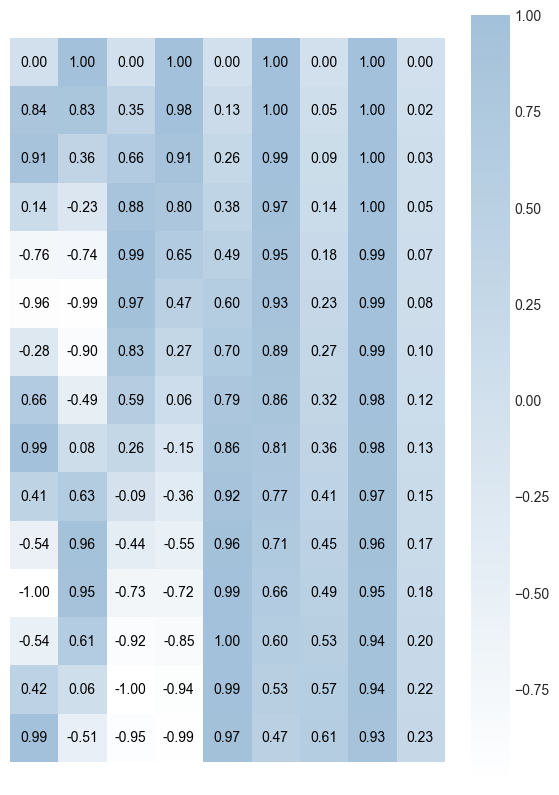

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from matplotlib.colors import LinearSegmentedColormap

pastel_cmap = LinearSegmentedColormap.from_list('pastel_blue', ['white', '#a3c1da'])

fig, axes = plt.subplots(1,1, figsize=[7,10])


cax = axes.imshow(embeddings, cmap=pastel_cmap, interpolation='nearest')
axes.set_xticks([])
axes.set_yticks([])
fig.colorbar(cax, ax=axes)

for i in range(sequence_length):
    for j in range(embedding_length):
        axes.text(j, i, f'{embeddings[i, j]:.2f}', ha='center', va='center', color='black')


plt.show()

The matrix above was generated using the Vaswani et al. (2017) method. It represents positional encodings for a sentence length of 15 and embedding length of 9. Notice that the values change quite quickly for the earlier index values, but tend to remain stable for the rightmost index positions.

Also, notice that all the values are nicely bounded in the range [-1,1] thanks to the choice of sinusoidal functions. This is crucial for deep neural networks since it prevents the exploding gradient problem.

Let's start by looking at adjacent pairs of embeddings - every $(sin(\theta), cos(\theta))$ pair can uniquely represent an angle between 0 and $2\pi$. One can use a [rotation matrix](https://blog.timodenk.com/linear-relationships-in-the-transformers-positional-encoding/) to calculate the angular difference at the same index positions.

However, this is periodic and not a valid distance measure, because $p_t \approx p_{\left\lfloor t+2\pi \right\rfloor}$

The solution to this is an ancient idea - place value - which is also the basis for the number system. We noticed above that the sine and cosine frequencies decay for larger indices. The rightmost index pair has a frequency which is nearly zero for a large embedding length.

In the decimal system, place value is calculated using $\sum_pn_p*b^p$, where n is the face value, b is the base and p is the position. for example,

$$
9876 = 9*10^3 + 8*10^2 + 7*10^1 + 6*10^0
$$

## How the Model Learns to Calculate Distances Between Tokens

It is possible for the model to learn a function $f(p_t, p_{t+k}) = k$ to obtain the distances between tokens.

$$
cos(\theta^{t+k} - \theta^{t}) = cos(\theta^{t+k})cos(\theta^k) + sin(\theta^{t+k})\sin(\theta^t) \\
sin(\theta^{t+k} - \theta^{t}) = sin(\theta^{t+k})cos(\theta^k) - cos(\theta^{t+k})\sin(\theta^t)
$$

Finally,

$$
(\theta_i^{t+k} - \theta_i^{t}) = arctan(\frac{sin(\theta_i^{t+k} - \theta_i^{t})}{cos(\theta_i^{t+k} - \theta_i^{t})}) \\
k = C_i * (\theta_i^{t+k} - \theta_i^{t})
$$

where $C_i$ converts angular difference to positional difference $(k)$ between tokens.


## The Clock-Faces Analogy

Each dimension-pair can be visualized as a hand on a clock face. The clocks get "slower" as you move from left to right. A single row of clocks encodes the position of an embedding in a sequence.

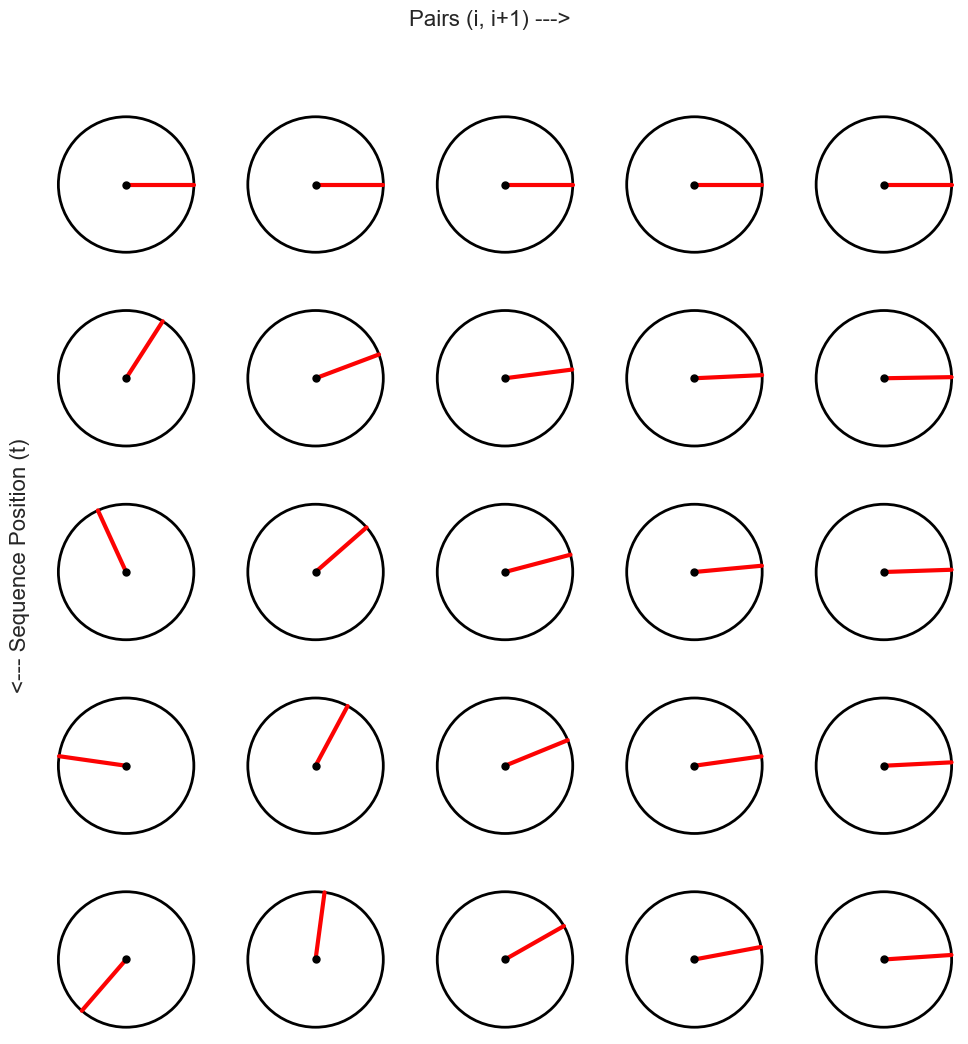

In [3]:
rows, cols = 5, 5  # Grid size
radius = 0.8  # Clock radius
total_clocks = rows * cols


fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.1)

cmap = plt.get_cmap('Reds')  # Hue-based gradient for 0 to 2π

def draw_radian_clock(i, j, x, y, angle, color):
    # Draw clock face
    clock_face = plt.Circle((0, 0), radius, edgecolor='black', facecolor='white', lw=2)
    ax = axes[i,j]
    ax.add_patch(clock_face)

    # Draw the hand extending to the edge of the circle
    ax.plot([0, radius * jnp.cos(angle)], [0, radius * jnp.sin(angle)], lw=3, color=color)

    # Center point
    ax.plot(0, 0, 'o', markersize=5, color='black')

    # Configure axis
    ax.set_aspect('equal')
    ax.axis('off')

for i in range(rows):
    for j in range(cols):
        # Compute the angle in radians for this clock (normalized between 0 and 2π)
        theta, x = pos(i, 2*j)
        _, y = pos(i, 2*j+1)

        # Get a color from the colormap based on the normalized angle
        #color = cmap(1 - theta / jnp.pi)

        # Draw the clock with a single hand
        draw_radian_clock(i, j, x, y, theta, "#fc0303")


fig.text(0.5, 0.95, "Pairs (i, i+1) --->", ha='center', fontsize=16)
fig.text(0.1, 0.5, "<--- Sequence Position (t)", va='center', rotation='vertical', fontsize=16)
plt.show()

## So Does This Work? 

To find out, let's train a linear function to calculate the distance $k$ between pairs of embeddings.

First, let's generate some sample word embeddings.



In [13]:
import jax
import jax.numpy as jnp

rng = jax.random.PRNGKey(42)

def generate_embeddings(rng, shape=(sequence_length, embedding_length), min_val=-0.1, max_val=0.1):
    embeddings = jax.random.uniform(rng, shape, minval=min_val, maxval=max_val)
    return embeddings

sem_embeddings = generate_embeddings(rng)

Next, let's generate the positional embeddings.

In [14]:
import jax.numpy as jnp

def generate_pos_embeddings(shape=(sequence_length, embedding_length)):

    embeddings = jnp.empty(shape)
    for row in range(shape[0]):
        for col in range(shape[1]):
            embeddings = embeddings.at[(row,col)].set(pos(row,col)[1])

    return embeddings

pos_embeddings = generate_pos_embeddings()

Let's add the embeddings to obtain the final word embeddings.

In [15]:
embeddings = embeddings + pos_embeddings

Let's train a simple 2 layer neural network and see if it can accurately predict the distance between two embeddings.

In [10]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

# Model
class PosDiffPredictor(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1)) 
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=embedding_length-1)(x)
        return x

# Loss function: cross-entropy
def cross_entropy_loss(logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=embedding_length-1)
    loss = optax.softmax_cross_entropy(logits, one_hot).mean()
    return loss

# Accuracy calculation
def compute_accuracy(logits, labels):
    predictions = jnp.argmax(logits, axis=-1)
    return jnp.mean(predictions == labels)

# Training step
@jax.jit
def train_step(state, batch):
    inputs, targets = batch

    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs)
        loss = cross_entropy_loss(logits, targets)
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Initialize the training state
def initialize_train_state(rng, model, input_shape):
    params = model.init(rng, jnp.ones(input_shape))['params']
    tx = optax.adam(learning_rate=1e-3)
    state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state

def generate_dataset(num_samples, dataset):

    i_values = jax.random.randint(rng, (num_samples,), 0, 10)
    j_values = i_values + jax.random.randint(rng + 1, (num_samples,), 0, 10 - i_values)
    j_values = jnp.clip(j_values, 0, 9)

    emb_i = dataset[i_values,:]
    emb_j = dataset[j_values, :]

    diff = j_values - i_values

    return jnp.stack([emb_i, emb_j], axis=1), diff


# Training loop for 10 epochs
def train_model(state, inputs, targets, num_epochs=10, batch_size=128):
    num_samples = inputs.shape[0]
    for epoch in range(num_epochs):
        # Shuffle data for each epoch
        perm = jax.random.permutation(jax.random.PRNGKey(epoch), num_samples)
        inputs, targets = inputs[perm], targets[perm]
        
        # Batch training
        for i in range(0, num_samples, batch_size):
            batch_inputs = inputs[i:i + batch_size]
            batch_targets = targets[i:i + batch_size]
            batch = (batch_inputs, batch_targets)
            state, loss = train_step(state, batch)
        
        logits = state.apply_fn({'params': state.params}, inputs)
        train_acc = compute_accuracy(logits, targets)
        if epoch % 20 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss:.8f}, Accuracy: {train_acc:.4f}')
    
    print(f'Epoch {epoch + 1}, Loss: {loss:.4f}, Accuracy: {train_acc:.4f}')
    return state


def predict(X, model_state):

    logits = model_state.apply_fn({'params': model_state.params}, X)
    probabilities = jax.nn.softmax(logits)
    Y = jnp.argmax(probabilities, axis=-1)
    return Y


# Initialize model state
model = PosDiffPredictor()
rng, sub_rng = jax.random.split(rng)
state = initialize_train_state(sub_rng, model, (1, 2, embedding_length))

# Generate dataset of differences
inputs, targets = generate_dataset(10000, embeddings)

# Train the model for 10 epochs
state = train_model(state, inputs, targets, num_epochs=200, batch_size=1024)

Epoch 1, Loss: 1.84998345, Accuracy: 0.3083
Epoch 21, Loss: 0.80019003, Accuracy: 0.8062
Epoch 41, Loss: 0.45875004, Accuracy: 0.9139
Epoch 61, Loss: 0.26499265, Accuracy: 0.9705
Epoch 81, Loss: 0.17593417, Accuracy: 0.9705
Epoch 101, Loss: 0.11469008, Accuracy: 0.9705
Epoch 121, Loss: 0.08093698, Accuracy: 0.9705
Epoch 141, Loss: 0.05569616, Accuracy: 0.9705
Epoch 161, Loss: 0.04355449, Accuracy: 0.9705
Epoch 181, Loss: 0.03342390, Accuracy: 0.9705
Epoch 200, Loss: 0.0237, Accuracy: 0.9705


Now, let's see if our trained model is able to predict the distance between two tokens in the training data accurately.

In [11]:
X = jnp.stack([dataset[3], dataset[5]], axis=0)
X = jnp.expand_dims(X, axis=0)
print(predict(X, state)[0])

2


It works! Looks like our model is able to calculate the distance between words, despite the 'noise' from the semantic embeddings. This tends to become more challenging in deep neural networks, but that's a topic for another time.

<script src="https://utteranc.es/client.js"
        repo="novastar53/novastar53.github.io"
        issue-term="pathname"
        theme="github-light"
        crossorigin="anonymous"
        async>
</script>